In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('Outcome', axis=1), data['Outcome'], random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=0)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Size of training set: 432   size of validation set: 144   size of test set: 192



In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [3, 5, 7, 9, 11, 13]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='f1',
                           return_train_score=True, verbose=1, n_jobs=-1)
grid_search.fit(X_trainval, y_trainval)

print("Best parameters: {}".format(grid_search.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': 7, 'n_estimators': 10}


In [5]:
param_grid = {'n_estimators': range(1, 10),
              'max_depth': [3, 5, 7, 9, 11, 13]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='f1',
                           return_train_score=True, verbose=1, n_jobs=-1)
grid_search.fit(X_trainval, y_trainval)

print("Best parameters: {}".format(grid_search.best_params_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'max_depth': 7, 'n_estimators': 7}


# Rebuild the model with the best parameters

In [6]:
rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                            max_depth=grid_search.best_params_['max_depth'], random_state=0)
rf.fit(X_trainval, y_trainval)

RandomForestClassifier(max_depth=7, n_estimators=7, random_state=0)

# Evaluate the model

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, auc

print(classification_report(y_test, rf.predict(X_test), target_names=['No Diabetes', 'Diabetes']))
print(confusion_matrix(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

 No Diabetes       0.81      0.88      0.84       130
    Diabetes       0.69      0.58      0.63        62

    accuracy                           0.78       192
   macro avg       0.75      0.73      0.74       192
weighted avg       0.77      0.78      0.78       192

[[114  16]
 [ 26  36]]


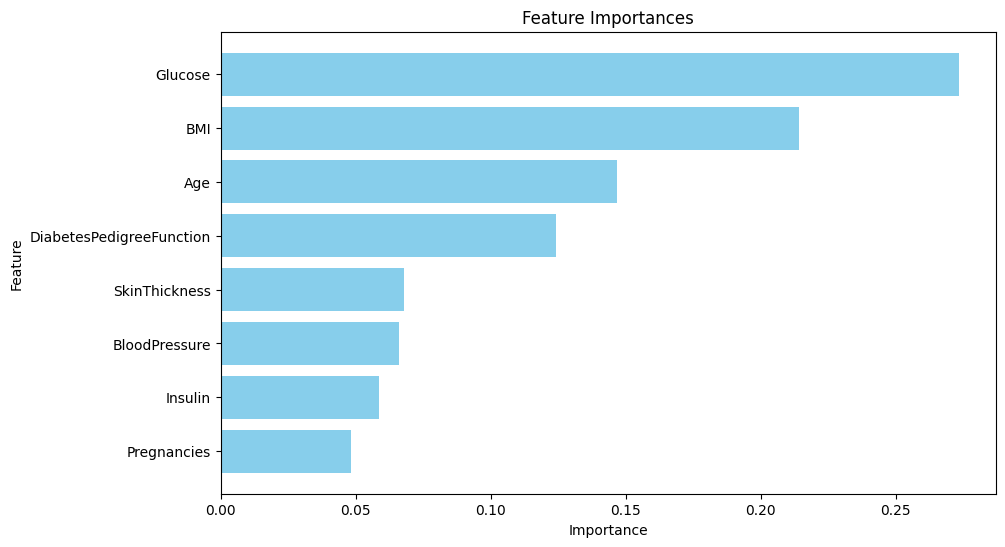

In [8]:
feature_importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


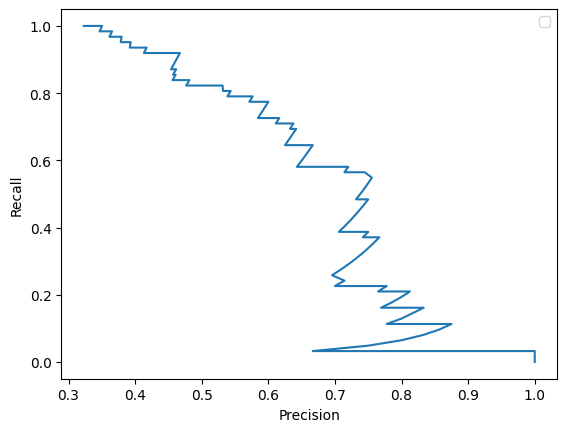

In [9]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

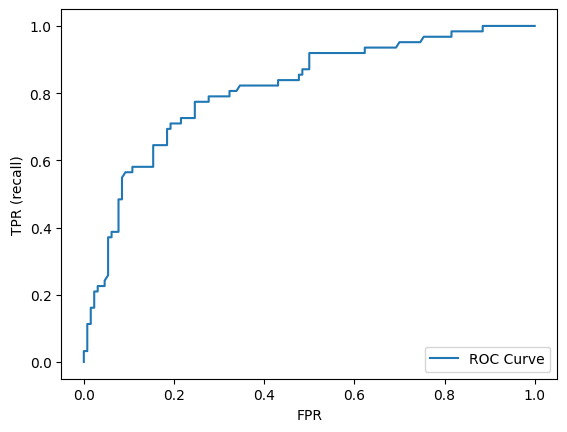

In [10]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

plt.legend(loc=4)

# Remove the least important features

In [11]:
print(importance_df.iloc[4:]['Feature'])

3    SkinThickness
2    BloodPressure
4          Insulin
0      Pregnancies
Name: Feature, dtype: object


In [12]:
X_test_less = X_test.drop(importance_df['Feature'].iloc[4:], axis=1)
X_trainval_less = X_trainval.drop(importance_df['Feature'].iloc[4:], axis=1)

In [13]:
X_trainval_less.head()

,Glucose,BMI,DiabetesPedigreeFunction,Age
762,89,22.5,0.142,33
127,118,33.3,0.261,23
564,91,32.4,0.601,27
375,140,39.2,0.528,58
663,145,37.9,0.637,40


In [14]:
param_grid = {'n_estimators': range(1, 10),
              'max_depth': [3, 5, 7, 9, 11, 13]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='f1',
                           return_train_score=True, verbose=1, n_jobs=-1)
grid_search.fit(X_trainval, y_trainval)

print("Best parameters: {}".format(grid_search.best_params_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'max_depth': 7, 'n_estimators': 7}


In [15]:
rf_lessFeatures = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                            max_depth=grid_search.best_params_['max_depth'], random_state=0)
rf_lessFeatures.fit(X_trainval_less, y_trainval)

RandomForestClassifier(max_depth=7, n_estimators=7, random_state=0)

In [16]:
print(classification_report(y_test, rf_lessFeatures.predict(X_test_less), target_names=['No Diabetes', 'Diabetes']))
print(confusion_matrix(y_test, rf_lessFeatures.predict(X_test_less)))

              precision    recall  f1-score   support

 No Diabetes       0.84      0.85      0.84       130
    Diabetes       0.67      0.66      0.67        62

    accuracy                           0.79       192
   macro avg       0.76      0.75      0.75       192
weighted avg       0.79      0.79      0.79       192

[[110  20]
 [ 21  41]]


# Remove rows with 0 values

In [17]:
data_cleaned = data[(data['Glucose'] != 0) &
                    (data['BMI'] != 0) &
                    (data['DiabetesPedigreeFunction'] != 0) &
                    (data['Age'] != 0)]

data_cleaned_less = data_cleaned.drop(importance_df['Feature'].iloc[4:], axis=1)

data_cleaned_less.describe()

,Glucose,BMI,DiabetesPedigreeFunction,Age,Outcome
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,121.941489,32.454654,0.473051,33.312500,0.351064
std,30.601198,6.928926,0.330108,11.709395,0.477621
min,44.000000,18.200000,0.078000,21.000000,0.000000
25%,99.750000,27.500000,0.244000,24.000000,0.000000
50%,117.000000,32.300000,0.377000,29.000000,0.000000
75%,141.000000,36.600000,0.627500,41.000000,1.000000
max,199.000000,67.100000,2.420000,81.000000,1.000000


In [18]:
from sklearn.model_selection import train_test_split

X_cleaned_trainval, X_cleaned_test, y_cleaned_trainval, y_cleaned_test = train_test_split(data_cleaned.drop('Outcome', axis=1), data_cleaned['Outcome'], random_state=0)

X_cleaned_train, X_cleaned_valid, y_cleaned_train, y_cleaned_valid = train_test_split(X_cleaned_trainval, y_cleaned_trainval, random_state=0)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_cleaned_train.shape[0], X_cleaned_valid.shape[0], X_cleaned_test.shape[0]))

param_grid = {'n_estimators': range(1, 10),
              'max_depth': [3, 5, 7, 9, 11, 13]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='f1',
                           return_train_score=True, verbose=1, n_jobs=-1)
grid_search.fit(X_cleaned_trainval, y_cleaned_trainval)

print("Best parameters: {}".format(grid_search.best_params_))

Size of training set: 423   size of validation set: 141   size of test set: 188

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'max_depth': 7, 'n_estimators': 5}


In [19]:
rf_clean = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                         max_depth=grid_search.best_params_['max_depth'], random_state=0)
rf_clean.fit(X_cleaned_trainval, y_cleaned_trainval)

RandomForestClassifier(max_depth=7, n_estimators=5, random_state=0)

In [20]:
print(classification_report(y_cleaned_test, rf_clean.predict(X_cleaned_test), target_names=['No Diabetes', 'Diabetes']))
print(confusion_matrix(y_cleaned_test, rf_clean.predict(X_cleaned_test)))

              precision    recall  f1-score   support

 No Diabetes       0.83      0.81      0.82       129
    Diabetes       0.61      0.64      0.63        59

    accuracy                           0.76       188
   macro avg       0.72      0.73      0.73       188
weighted avg       0.76      0.76      0.76       188

[[105  24]
 [ 21  38]]


# This did not imporve the model